In [46]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print("Using TensorFlow version:", tf.__version__)

# Pour reproduire un comportement stable (optionnel)
tf.random.set_seed(42)

Using TensorFlow version: 2.16.2


## 1. Chargement du dataset

In [47]:
DATA_DIR = "screw_dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20
)

val_datagen = ImageDataGenerator()

# Chargement des images avec augmentation pour l'entraînement
dataset = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Extraction des images et labels
all_images = []
all_labels = []
for images, labels in dataset:
    all_images.append(images)
    all_labels.append(labels)
    if len(all_images) * BATCH_SIZE >= dataset.samples:
        break

X = np.concatenate(all_images, axis=0) / 255.0  # Normalisation 
y = np.concatenate(all_labels, axis=0)

# Mélange des données
indices = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

# Division train/validation/test (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_shuffled, y_shuffled, train_size=0.7, stratify=y_shuffled, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42
)

# Création des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

Found 1152 images belonging to 2 classes.


## 2. Définition d'un modèle simple
On définit un modèle CNN

In [48]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),  
    layers.MaxPooling2D(2, 2),  
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model.summary()

/Users/christel/Desktop/HETIC/gestion_situation_crise/Screw/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │        43,265 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,849 (261.13 KB)

 Trainable params: 66,849 (261.13 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Entraînement du modèle

In [49]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Réduction du LR par un facteur de 2
    patience=3,       # Attendre 3 époques sans amélioration avant de réduire
    min_delta=0.001,  # Seuil minimum de variation pour considérer une amélioration
    min_lr=1e-6       # LR minimum pour éviter d'aller trop bas
)

class_weights = {0: 1., 1: 3.}

# Entraînement
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset, 
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights, 
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7537 - loss: 1.0159 - recall: 0.9712 - val_accuracy: 0.7514 - val_loss: 0.5702 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7672 - loss: 0.8490 - recall: 1.0000 - val_accuracy: 0.7514 - val_loss: 0.6271 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7672 - loss: 0.7872 - recall: 1.0000 - val_accuracy: 0.7514 - val_loss: 0.6107 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7672 - loss: 0.7885 - recall: 1.0000 - val_accuracy: 0.7514 - val_loss: 0.6082 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7672 - loss: 0.7778 - recall: 1.0000 - val_accuracy: 0.7514 - val_loss: 0.6117 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


2025-03-19 20:18:09.937962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


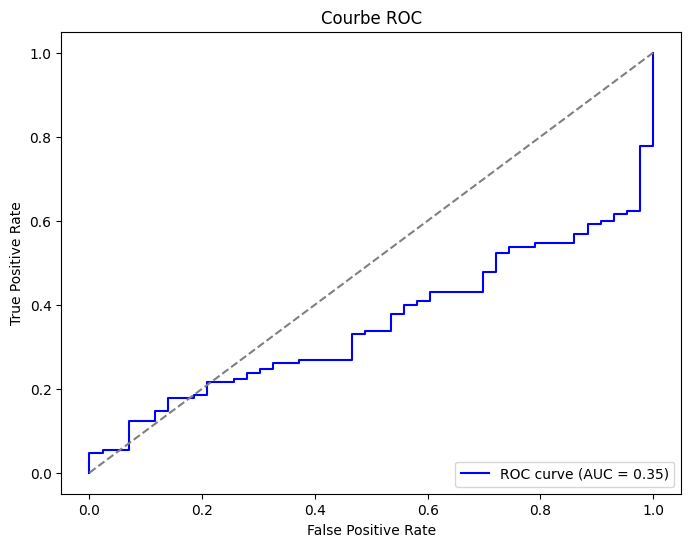

In [50]:
# Ajout de la courbe ROC et de l'AUC après l'entraînement
y_true = []
y_scores = []

for x_batch, y_batch in val_dataset:
    y_true.extend(y_batch.numpy())  # Vraies classes (0 ou 1)
    y_scores.extend(model.predict(x_batch).flatten())  # Scores de probabilité

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

"""
# Calcul du Youden's J statistic pour trouver le meilleur seuil
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)  # Index du seuil optimal
optimal_threshold = thresholds[optimal_idx]  # Seuil optimal

print(f"Seuil optimal trouvé : {optimal_threshold:.4f}")

y_pred = (y_scores >= optimal_threshold).astype(int)  # Appliquer le seuil optimal

"""

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

## 4. Évaluation sur le même dataset

In [51]:
# Obtenir les probabilités des prédictions sur le test set
y_scores_test = model.predict(X_test).flatten()  # Sorties sigmoïdes entre 0 et 1

# Appliquer le seuil optimal trouvé avec la courbe ROC
optimal_threshold = 0.75  
y_pred_test = (y_scores_test >= optimal_threshold).astype(int)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)  # Ajout du F1-score

# Affichage des résultats
print(f"Accuracy avec seuil optimal ({optimal_threshold:.4f}) : {accuracy:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step
Accuracy avec seuil optimal (0.7500) : 0.7514
Précision : 0.7514
Recall : 1.0000
F1-score : 0.8581
